# Multi-Frame Motion Deblur Simulations
This notebook generates a simulation object, solves the linear inverse problem, and saves the dataset in the iotools.Dataset format.

In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import scipy.misc as misc
import time
import sys
import itertools
import math
import imageio
import skimage as sk

# Libwallerlab imports
from libwallerlab.algorithms import iterative as iterative
from libwallerlab.opticsalgorithms.motiondeblur import blurkernel 
from libwallerlab.operators import operators as ops
from libwallerlab.utilities import displaytools, iotools

from libwallerlab.algorithms import objectivefunctions
from libwallerlab.algorithms import regularizers
from libwallerlab.operators import proximal as proxops
from libwallerlab.utilities.opticstools import Ft, iFt

## Flow of Notebook
1. Generate Object
2. Generate Measurements (Images)
3. Solve Inverse Problem
4. Save measurements and blur kernels in accurate libwallerlab.utilities.iotools.Dataset format

### To-Do
- // linear_y kernels don't extend whole way
- // multi-pass kernels
- // Add Sarah's PGD kernel optimization methods
- // Find out why result is not converging to correct values
- // save/load to lwl dataset format
- Add nesterov acceleration
- Implement CG
- Implement FISTA
- clean up blurkernel.py

# Define Motion Blur Parameters

In [28]:
# Image to use when generating object
object_file_name = '../../../../../common/test_images/brain_to_scan.png'

# Color channel to use when generating object
object_color_channel = 2

# Illumination vector generation type
blur_vector_type = 'pseudo_random' # 'random_phase' # can be strobe, constant, random, random_phase, projected_gradient_descent

# Motion scanning type
scan_type = 'raster_linear' # can be linear_x, linear_y, raster, raster_custom (add more here)

# Flag to scan entire object in multiple times (True) or in individual segments of a single pass (False)
full_object_multi_pass = 0

# Method of padding object (for convolution support)
object_edge_pad_type = 'mean'

# Use spectrally-variant blur kernel (single-led flickering)

## NOT WORKING YET ##
use_spectrally_variant_blur = False

# Illumination throughput coefficient ( \in [0,1] )
throughput_coefficient = 0.5

# Image size to simulate
image_size = np.array([32, 32])

# Object size to image size ratio (>=1, integer)
object_size_ratio = 3

# Redundancy in measurements (> 1 means extra pixels are recorded, <1 means not enough)
measurement_redundancy = 1

# Directory to save output in
simulation_output_dir = '/home/sarah/Dropbox/deblurring/COSI/data/simulations/blurred'
# '/Users/zfphil/develop/datasets/'

# Generate Object

## Load Object

Object size is 96 x 96


/home/sarah/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


<IPython.core.display.Javascript object>


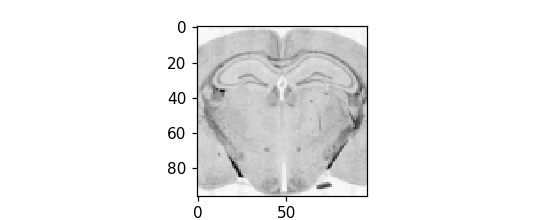

In [29]:
# Load object
brain = imageio.imread(object_file_name)

# Generate object with correct size
object_size_0 = np.round(np.array([object_size_ratio * image_size[0], object_size_ratio * image_size[1] * (brain.shape[1] / brain.shape[0])])).astype(np.int) # image_size #* 3
# brain_cropped = misc.imresize(brain, size=object_size_0) / 255.
brain_cropped = misc.imresize(brain, size=object_size_0) / 255.

# Determine object size
if scan_type == 'linear_y':
    brain_cropped = brain_cropped[:image_size[0]*object_size_ratio, :image_size[1]]
elif scan_type in ['linear', 'linear_x']:
    brain_cropped = brain_cropped[:image_size[0], :image_size[1]*object_size_ratio]
elif scan_type not in []:
    #brain_cropped = brain_cropped[:image_size[0]*object_size_ratio, :image_size[1]*object_size_ratio]
    center_pad = int((brain_cropped.shape[1] - image_size[1]*object_size_ratio)/2)
    brain_cropped = brain_cropped[:image_size[0]*object_size_ratio, center_pad:(image_size[1]*object_size_ratio+center_pad)]

# Redefine object size
# new_size = np.round([object_size_0[0], object_size_0[0] * (brain.shape[1] / brain.shape[0])]).astype(np.int)
object_color_channel = 2 # Choose one of RGB channels (TODO: implement color)
object_true = brain_cropped[:, :, object_color_channel] # remove alpha
object_size_0 = object_true.shape[:2]
print("Object size is %d x %d" % (object_size_0[0], object_size_0[1]))

# Plot
plt.figure(figsize = (5,2))
plt.imshow(object_true, cmap='gray')
# plt.axis('off')

# Generate Blur Pathway

0
?
(96, 96)
Image size requires 3 x 3 images
kernel 0 has length 32 and min sv 1.00
kernel 1 has length 32 and min sv 0.95
kernel 2 has length 32 and min sv 1.00
kernel 3 has length 32 and min sv 1.00
kernel 4 has length 32 and min sv 1.00
kernel 5 has length 32 and min sv 0.99
kernel 6 has length 32 and min sv 1.00
kernel 7 has length 32 and min sv 1.00
kernel 8 has length 32 and min sv 1.06
9


<IPython.core.display.Javascript object>


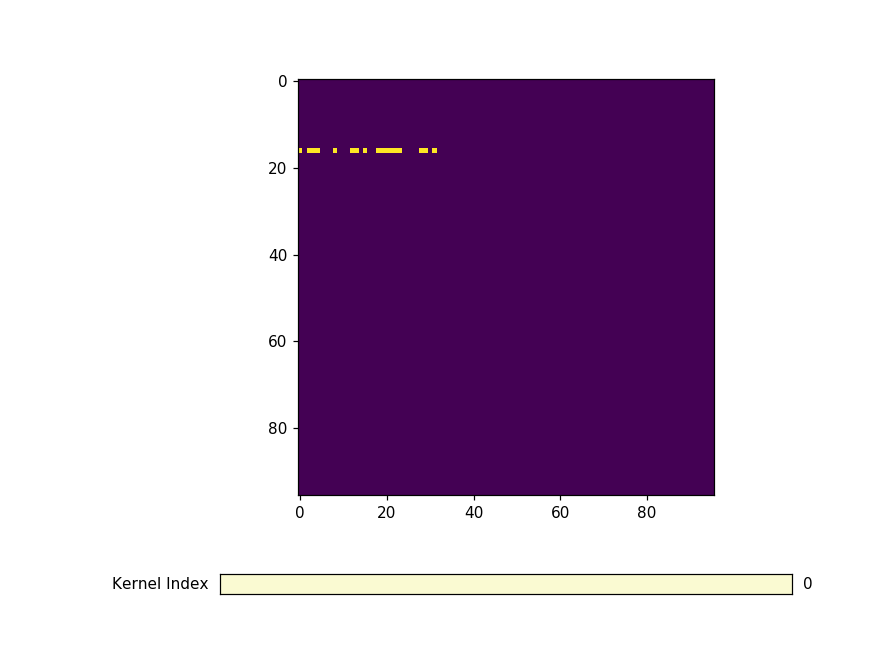

/home/sarah/anaconda3/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [30]:
# Generate positions
if scan_type in ['linear_x', 'linear', 'raster_major_x', 'raster']:
    # Generate a raster (or linear) scan in x
    point_list_segmented = blurkernel.genRasterMotionPathway(object_size_0, image_size, 
                                                             full_object_multi_pass=full_object_multi_pass, 
                                                             measurement_redundancy=measurement_redundancy)
elif scan_type in ['linear_y', 'raster_major_y']:
    # Generate a raster (or linear) scan in x, then rotate 90 degrees for a y scan
    point_list_segmented = np.flip(blurkernel.genRasterMotionPathway((object_size_0[1], object_size_0[0]), image_size, 
                                                                     full_object_multi_pass=full_object_multi_pass,
                                                                    measurement_redundancy=measurement_redundancy), axis=2)
elif scan_type in ['raster_major_both']:
    assert measurement_redundancy == 2
    point_list_segmented_x = blurkernel.genCustomRasterPathway(image_size, object_size_0, \
                                                               corner_fn=blurkernel.generate_open_corner)
    temp = blurkernel.genCustomRasterPathway(np.flip(image_size,axis=0), np.flip(object_size_0,axis=0), \
                                                               corner_fn=blurkernel.generate_open_corner)
    point_list_segmented_y = []
    for point in reversed(temp):
        point_list_segmented_y.append(np.flipud(np.flip(point, axis=1)))
    point_list_segmented = np.concatenate((point_list_segmented_x, point_list_segmented_y), axis=0)
elif scan_type in ['raster_2x']:
    point_list_segmented_1 = blurkernel.genCustomRasterPathway(image_size, object_size_0, \
                                                               corner_fn=blurkernel.generate_open_corner, measurement_redundancy=measurement_redundancy/2)
    temp = blurkernel.genCustomRasterPathway(image_size, object_size_0, \
                                                               corner_fn=blurkernel.generate_open_corner, measurement_redundancy=measurement_redundancy/2)
    point_list_segmented_2 = []
    for point in reversed(temp):
        point_list_segmented_2.append(np.flipud(point))
    point_list_segmented = np.concatenate((point_list_segmented_1, point_list_segmented_2), axis=0)
elif scan_type in ['raster_custom']:
    point_list_segmented = blurkernel.genCustomRasterPathway(image_size, object_size_0, \
                                                             corner_fn=blurkernel.generate_open_corner, \
                                                             measurement_redundancy=measurement_redundancy)
elif scan_type in ['raster_linear']:
    point_list_segmented = blurkernel.genLinearRasterMotionPathway(object_size_0, image_size, 
                                                             full_object_multi_pass=full_object_multi_pass, 
                                                             measurement_redundancy=measurement_redundancy)
elif scan_type in ['raster_linear_short']:
    full_point_list_segmented = blurkernel.genLinearRasterMotionPathway(object_size_0, image_size, 
                                                             full_object_multi_pass=full_object_multi_pass, 
                                                             measurement_redundancy=measurement_redundancy)
    point_list_segmented = []
    for point_list in full_point_list_segmented:
        index_pad = int(len(point_list)/4)
        point_list_segmented.append(point_list[index_pad:-index_pad])
else:
    raise NotImplementedError('scan type [%s] is not implemented yet.' % scan_type)

# Generate illumination vectors using quick and cheap optimization
illum_vector_list = []
for kernel_index, positions in enumerate(point_list_segmented):
    if blur_vector_type == 'constant':
        illum_vector_list.append(np.ones(positions.shape[0]))
    elif blur_vector_type == 'strobe':
        illum_vector_list.append(np.zeros(positions.shape[0]))
        illum_vector_list[-1][positions.shape[0] // 2] = throughput_coefficient
    elif blur_vector_type == 'random':
        illum_vector_list.append(np.random.rand(positions.shape[0]))
        illum_vector_list[-1] = illum_vector_list[-1] / np.sum(illum_vector_list[-1]) * throughput_coefficient
    elif blur_vector_type == 'random_phase':
        k, v = blurkernel.genIllum_pseudoRandom_len(len(positions))
        illum_vector_list.append(v)
    elif blur_vector_type == 'projected_gradient_descent':
        blur_kernel_fourier = blurkernel.positionListToBlurKernelMap(object_size_0, positions, return_fourier=True)
        def blurMapCol(i):
            return (blur_kernel_fourier[i]).reshape(-1) #/ len(positions)
        result = blurkernel.genIllum(blurMapCol, len(blur_kernel_fourier),  
                                     maxiter=100, throughputCoeff=throughput_coefficient, 
                                     resultType='final', verbose=False)
        illum_vector_list.append(result['xopt'])
        print('kernel %d has length %d and condition number %.2f' % (kernel_index, len(positions), result['fopt']))
    elif blur_vector_type == 'pseudo_random':      
        illum, sv = blurkernel.genIllum_randomSearch(positions, object_size_0,
                                     maxiter=100, throughputCoeff=throughput_coefficient)
        illum_vector_list.append(illum)
        print('kernel %d has length %d and min sv %.2f' % (kernel_index, len(positions), sv))
    else:
        raise NotImplementedError('Illumination vector type %s is not implemented.' % blur_vector_type)
print(len(point_list_segmented))
# Generate blur kernel maps for each frame
blur_kernel_list = np.zeros((len(point_list_segmented), object_size_0[0], object_size_0[1]))
for frame_index in range(len(illum_vector_list)):
    for position_index, position in enumerate(point_list_segmented[frame_index]):
        blur_kernel_list[frame_index, position[0], position[1]] = illum_vector_list[frame_index][position_index]
        
# Define cropped object sizes and crop true image
object_size = blur_kernel_list[0].shape

# Show blur kernels
displaytools.show3dArray(blur_kernel_list, figsize=(8,6))

# Generate Measurements (Non-circular convolution)

<IPython.core.display.Javascript object>


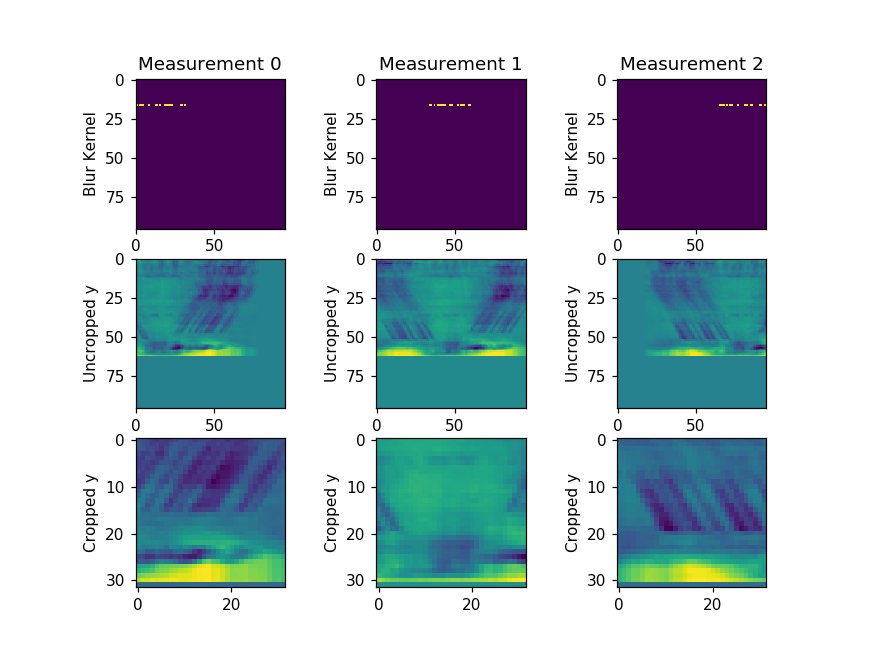

In [31]:
# Determine maximum kernel support in x/y for all blur kernels in blur_kernel_list. This is how much we will pad our object by.
support_size_list = []
for blur_kernel in blur_kernel_list:
#     support_size_list.append(blurkernel.getBoundingBox(blur_kernel, return_roi=True).size())
    support_size_list.append(blurkernel.getPositionListBoundingBox(point_list_segmented).size())
max_kernel_support = np.max(np.asarray(support_size_list),axis=0)

# Generate pad operator for object support
object_size_padded = (np.asarray(object_size) + max_kernel_support).tolist() # Add to object_size
W_object_support = ops.Crop(object_size_padded, object_size, crop_start=(max_kernel_support[0] // 2, max_kernel_support[1] // 2)) # Add support

# Pad object with random values (to simulate an extended object)
object_extended = W_object_support.H * object_true.reshape(-1).astype(np.complex64)
if object_edge_pad_type == 'random':
    object_extended += (1. - W_object_support.H * np.ones(object_true.size, dtype=np.complex64)) * np.random.rand(np.prod(object_size_padded))
elif object_edge_pad_type == 'zeros':
    object_extended += (1. - W_object_support.H * np.zeros(object_true.size, dtype=np.complex64))
elif object_edge_pad_type == 'ones':
    object_extended += (1. - W_object_support.H * np.ones(object_true.size, dtype=np.complex64))
elif object_edge_pad_type == 'mean':
    object_extended += (1. - W_object_support.H * np.mean(object_true) * np.ones(object_true.size, dtype=np.complex64))
elif object_edge_pad_type == None:
    object_extended = object_true
    object_size_padded = object_true.shape
    W_object_support = ops.Identity(object_true.shape)
    
# Define crop operator for object to image
W = ops.Crop(object_size, image_size)

A_list = []
y_list = []
C_list = []
y_list_uncropped = []

# Generate forward model operators for each blur kernel
for blur_kernel_index, blur_kernel in enumerate(blur_kernel_list):
    blur_kernel = blur_kernel.astype(np.complex64) / np.sum(np.abs(blur_kernel.astype(np.complex64)))
    
    # 2D Convolution Operator with the given kernel
    C = ops.Convolution(object_size_padded, (W_object_support.H * blur_kernel.reshape(-1)).reshape(object_size_padded))
    C_list.append(C)
    
    # Forward operator with image crop and full object crop
    A_list.append(W * W_object_support * C)
    
    # Generate measurements using padded convolution
    y_list.append(A_list[-1] * object_extended.reshape(-1).astype(np.complex64))
    
    # Store uncropped measurements so we can observe what the padding is actually doing
    y_list_uncropped.append(W_object_support * C * object_extended.reshape(-1).astype(np.complex64))
    
# Show first three blur kernels, uncropped measurements, and cropped measurements
plt.figure(figsize=(8,6))
nshow = min(3, len(blur_kernel_list))
for i in range(nshow):
    plt.subplot(3, nshow, i+1)
    plt.imshow(blur_kernel_list[i], interpolation='none')
    plt.title('Measurement '+str(i))
    plt.ylabel('Blur Kernel')
    
    plt.subplot(3, nshow, nshow + i + 1)
    plt.imshow(np.abs(y_list_uncropped[i].reshape(object_size)))
    plt.ylabel('Uncropped y')
    
    plt.subplot(3, nshow, nshow*2 + i + 1)
    plt.imshow(np.abs(y_list[i].reshape(image_size)))
    plt.ylabel('Cropped y')

# Recovery via Gradient Descent

In [32]:
# Generate measurements from image list
y_full = np.empty(0, dtype=np.complex64)
for y in y_list:
    y_full = np.append(y_full, y)
    
# Normalize measurements
y_mean = np.mean(np.abs(y_full))  
y_full /= y_mean

# Generate full A Operator
A_full = ops.Vstack(Operators=A_list)

# Initialization: choosing a "good" coefficient value will help in convergence
initialization = np.ones(object_size_padded, dtype=np.complex64).reshape(-1)

# Define cost function
objective = objectivefunctions.L2(A_full, y_full)

solve_method = 'cg'
display_type = 'text'
# Solve linear inverse problem

if solve_method is 'gd':
    iteration_count = 3000
    object_recovered = iterative.GradientDescent(objective).solve(initialization=initialization, 
                                                                  step_size=1,
                                                                  iteration_count=iteration_count, 
                                                                  display_type=display_type, 
                                                                  display_iteration_delta=(iteration_count // 10))
elif solve_method is 'cg':
    iteration_count = 300
    object_recovered = iterative.ConjugateGradient(A_full, y_full).solve(initialization=initialization, 
                                                                  iteration_count=iteration_count, 
                                                                  display_type=display_type,
                                                                  use_log_y=False,
                                                                  use_log_x=False,
                                                                  debug=True,
                                                                  display_iteration_delta=(iteration_count // 10))
elif solve_method is 'fista':
    iteration_count = 300

    object_recovered = iterative.Fista(objective, proximal_operator=proxops.positivity).solve(initialization=initialization, 
                                                                                              iteration_count=iteration_count, 
                                                                                              display_type=display_type,
                                                                                              use_log_y=True,
                                                                                              use_log_x=False,
                                                                                              debug=True,
                                                                                              display_iteration_delta=(iteration_count // 10))

|  Iter  |      Cost      | Elapsed time (sec) |
+ ------ + -------------- + ------------------ +
|    0   |    9.87e-01    |        0.00        |
|   30   |    7.33e-05    |        2.50        |
|   60   |    4.26e-06    |        4.93        |
|   90   |    5.85e-07    |        7.39        |
|  120   |    7.09e-08    |        9.98        |
|  150   |    7.54e-09    |       12.48        |
Diverged at iteration 156


## Show Results

Recovery SSE is 1.97


<IPython.core.display.Javascript object>


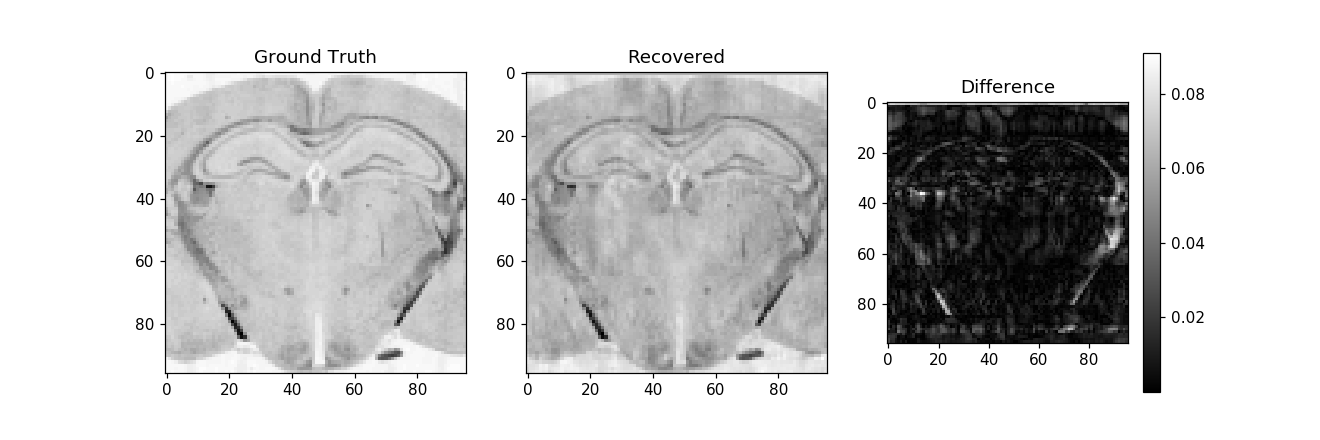

In [33]:
object_recovered_crop = (W_object_support * object_recovered).reshape(object_size)

# normalize true object (because zero-frequency is irrelevent and recon is zero-mean)
object_true_normalized = object_true / np.mean(object_true)
object_recovered_crop = object_recovered_crop / np.mean(object_recovered_crop)
# Calculate SSE
print('Recovery SSE is %.2f' % np.sum(np.abs(object_true_normalized - object_recovered_crop) ** 2))

plt.figure(figsize=(12, 4)) 
plt.subplot(1,3,1); i_true = plt.imshow(np.abs(object_true_normalized), cmap='gray'); plt.title('Ground Truth')
plt.subplot(1,3,2); i_rec = plt.imshow(np.abs(object_recovered_crop), cmap='gray'); plt.title('Recovered');# i_rec.set_clim(i_true.get_clim())
plt.subplot(1,3,3); plt.imshow(np.abs(object_true_normalized - object_recovered_crop), cmap='gray'); plt.colorbar(); plt.title('Difference')

## Save Results in lwl format

In [53]:
import datetime
dataset = iotools.Dataset()

# Hard-code a few blur parameters
exposure_time_s = 1

# Store true object
dataset.metadata.simulation.object_true = object_true

# Define metadata
dataset.metadata.objective.na = 0.25
dataset.metadata.objective.mag = 10
dataset.metadata.system.mag = 2
dataset.metadata.illumination.spectrum.center = {'g' : 0.53}
dataset.metadata.illumination.device_name = 'simulation_single_led'
dataset.metadata.illumination.state_list.design = np.asarray([[0,0]])
dataset.metadata.position.device_name = 'simulation'
dataset.metadata.camera.pixel_size_um = 6.5 #um
dataset.metadata.system.eff_pixel_size_um = dataset.metadata.camera.pixel_size_um / dataset.metadata.system.mag

# Set frame_list
y_list_raster = [y.reshape(image_size) for y in y_list]
dataset.frame_list = np.real(np.asarray(y_list_raster))
dataset.frame_list = (dataset.frame_list / np.max(dataset.frame_list) * 65535.).astype(np.uint16)

# Define frame_state_list, which determines the blur kernel. NOTE that we do not save the blur kernel directly - this is to be consistent with actual data
dataset.frame_state_list = []
for kernel_index in range(len(blur_kernel_list)):
    

    blur_vector = illum_vector_list[kernel_index]
    
    # Generate position metadata (Assume unit exposure and pixel units for simplicity)
    position_sequence = []
    for position_index, position in enumerate(point_list_segmented[kernel_index]):
        if blur_vector[position_index] > 0:
            position_sequence.append([{'index' : None,
                                           'value' : {
                                               'y' : int(position[0]),
                                               'x' : int(position[1]),
                                               'units' : 'pixels'},
                                           'time_sequence_index' : position_index
                                      }])

    # Generate illumination metadata (Assume single-led illumination for simplicity)
    illumination_sequence = []
    for time_sequence_index in range(len(illum_vector_list[kernel_index])):
        if blur_vector[time_sequence_index] > 0:
            illumination_sequence.append([{'index' : 0, 
                                          'time_sequence_index' : time_sequence_index,
                                          'value' : {'g' : float(blur_vector[time_sequence_index])}}])

    time_sequence_s = (exposure_time_s * np.arange(len(point_list_segmented[kernel_index])) / len(point_list_segmented[kernel_index])).tolist() 
    dataset.frame_state_list.append({'illumination' : illumination_sequence, 'position' : position_sequence, 'time_sequence_s' : time_sequence_s})
    
meta = dataset.save(dataset_path=simulation_output_dir + '/' + scan_type + '_' + blur_vector_type + '_')

Wrote dataset to directory: /home/sarah/Dropbox/deblurring/COSI/data/simulations/blurred/raster_strobe_2018_01_15_14_03_26/


## Save Results in .npz

In [34]:
if not full_object_multi_pass:
    num_image_per_scan = str(len(blur_kernel_list))
    num_full_scans = str(1)
elif full_object_multi_pass < 1:
    num_image_per_scan = str(2)
    num_full_scans = str(int(len(blur_kernel_list) / 2))
else:
    num_image_per_scan = str(1)
    num_full_scans = str(len(blur_kernel_list))
    
savestring = simulation_output_dir + '/' + scan_type + '_' + blur_vector_type + '_' + num_image_per_scan + 'x' + num_full_scans

np.savez(savestring, object_true=object_true, image_size=image_size, object_edge_pad_type=object_edge_pad_type, point_list_segmented=point_list_segmented, illum_vector_list=illum_vector_list, y_list=y_list)

In [22]:
savestring

'/home/sarah/Dropbox/deblurring/COSI/data/simulations/blurred/raster_random_phase_18x1'